# CMB bolometers:  optical loading and noise
_(J. Ruhl, ruhl@case.edu, 4/6/2019)_
<br>
In this notebook we take a given experiment's optical configuration, calculate loading on bolometer, and then calculate its NEP and NET given a small number of TES-related inputs.

Most of this notebook goes through how one does the relevant calculations for a single, specified case.  If you get to the end, we'll introduce some functions implementing all this that can be used to loop over parameters of interest.

In [144]:
import numpy as np
import matplotlib.pyplot as plt
import jr_util as jr  # a library of blackbody-related functions
%matplotlib inline
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [10, 5]

c= 2.99792458e8
h = 6.626068e-34
k = 1.3806503e-23
Tcmb = 2.725

### Optical setup
Let's define the optical setup.  We do this by specifying elements from the bolometer outward.  We'll do this for a canonical 150GHz "small aperture telescope" at the South Pole, ie no warm mirrors.

In [5]:
# Define the optical elements, for calculating optical efficiency, 
# optical loading, and photon noise.
# These need to be in order, from detector to CMB
optics = []
optics.append({'name':'300mK feed',   'eps':0.05, 'T':0.1})
optics.append({'name':'300mK filter', 'eps':0.05, 'T':0.1})
optics.append({'name':'4K lenses',    'eps':0.05, 'T':4.0 })
optics.append({'name':'Cold stop',    'eps':0.10, 'T':1.5 })   # changes in loop
optics.append({'name':'5K lens',      'eps':0.10, 'T':5.0 })
optics.append({'name':'5K filter',    'eps':0.05, 'T':5.0 })
optics.append({'name':'50K filter',   'eps':0.05, 'T':50.0 })
optics.append({'name':'window',       'eps':0.02, 'T':280.0 })  
optics.append({'name':'atm',          'eps':0.07, 'T':230.0 })
optics.append({'name':'CMB',          'eps':1.,   'T':2.73 })

# Set up optical properties;  divide into bins of width band_resolution
# Generic:  30% banwidth
#
band_center = 150.0  #GHz
band_width = 0.3*band_center
band_resolution = band_width/1000.   
nuGHZ=np.arange(band_center-0.5*band_width, band_center+0.5*band_width, band_resolution)
nu = nuGHZ*1.e9

## Photon loading and noise
Now that the system is defined, we'll loop over optical elements (starting at the detector and going outward, so we can keep track of accumulated optical efficiency) and sum up the optical loading and photon noise contributions.  Both of these are based on the photon occupation number, $ n = \frac{1}{e^x -1}$, where $x = h\nu/kT$.
<br><br>
Note that we will do this calculation for single-mode, single-polarization detectors.

In [42]:
# Calculate power load and photon NEP, by summing from the detector outward.
# First, initialize the things we'll be summing into.
NEP2_photon_total = 0.0
Qtot = 0.0
#
# Then initialize the optical efficiency, which starts out as one.
eta_tot = 1.0 
#
# Now set up convenience factors.
# Multiply both of these by Nmodes*Npol if those are not unity.
noise_prefactor = 2*2*((h**2)*(detector['nu']**2))  

# Loop over optical sources, from detector to sky.
for i in range(len(optics)):

    # Note that detector['nu'] is typically a vector.
    x = h*detector['nu']/(k*optics[i]['T'])

    #occupation number; this is eps*eta_tot*band/(e^x -1),
    # where eta_tot is the optical efficiency from the detector to this element.
    n = eta_tot*optics[i]['eps']/(np.exp(x)-1.)    

    # photon power on bolometer at each freq
    P = h*detector['nu']*n #power per mode per Hz; times Nmodes*Npol if those are not 1.

    #Integrate P to get the total power integrated across band
    optics[i]['Q'] = np.trapz(P, detector['nu'])

    #photon noise integral
    integrand = noise_prefactor*(n + n**2) 
    NEP2_photon_i = np.trapz(integrand, detector['nu'])
    optics[i]['NEP_photon'] = np.sqrt(NEP2_photon_i)  # so we can keep track of which elements are dominant in noise.

    # update eta_tot for the next loop through here
    # eta_tot is the optical effiency between the relevant element and the bolo.
    optics[i]['eta_to_bolo'] = eta_tot
    if optics[i]['name'] != 'CMB':
        eta_tot = eta_tot*(1-optics[i]['eps'])   # we want the efficiency to "outside the atmosphere"

    #sum powers and NEP^2 to get total (Note that NEP's add in quadrature)
    Qtot = Qtot + optics[i]['Q']
    NEP2_photon = NEP2_photon + NEP2_photon_i
    ####### end for loop over sources

NEP_photon = np.sqrt(NEP2_photon)
print('eta_tot = %4.3f' % (eta_tot))
print('Qtot = %4.2e W' % (Qtot))
print('NEP_photon = %4.2e W/sqrt(Hz)' % (NEP_photon))

eta_tot = 0.571
Qtot = 9.54e-12 W
NEP_photon = 1.23e-16 W/sqrt(Hz)


## Conversions from power to K_RJ and K_cmb
So far, we've calculated the total optical power on the detector, and calculated the photon NEP.  Before we calculate detector-related NEPs (like phonon and Johnson noise), let's calculate the conversion factor from NEP to uK_cmb, and to uK_RJ. 

In [43]:
# Now that we have eta_tot, we can do conversions to T_RJ, T_cmb units.
#
# dP_bolo/dT_RJ, referenced to celstial_sphere (ie what dT_RJ do you need there to create dP_bolo)
RJintegrand = k*eta_tot*np.ones(detector['nu'].size)   
dPdT_RJ = np.trapz(RJintegrand, detector['nu'])

# dP/dT_cmb, again referenced to T at celestial sphere
x = h*detector['nu']/(k*Tcmb)
AOmega = c**2 / detector['nu']**2  # single mode
integrand2 = AOmega*(eta_tot*h**2*(detector['nu']**4))*np.exp(x)/\
  (k*(c**2)*(Tcmb**2)*(np.exp(x)-1.0)**2)
dPdT_cmb = np.trapz(integrand2, detector['nu'])

Note that we've started to build a dictionary called "detector", which is going to hold
a lot of quantities relevant to that.  Let's put some things in there before we go
and calculate detector noise contributions.

In [44]:
# Record all the converted total quantities
T_RJ_tot = Qtot/dPdT_RJ
NET_photon_RJ = NEP_photon/dPdT_RJ
NET_photon_cmb = NEP_photon/dPdT_cmb

In [45]:
# bolometer parameters;  
# these are fmux appropriate
#
T_coldstage = 0.1 #K
T_bolo=2*T_coldstage #note: we use Psat, n, and these T's to calculate dynamic G
n = 2.75  #G index - 3 for insulators

# Set the total power on the detector based on the calculated optical power.
P_sat = 2.0 *Qtot

#
# Electrical properties;  appropriate for fmux in this example.
R_bolo = 1.5 #ohms (operating point)
R_load = 0.03 #ohms (shunt)
alpha = 10.0 #d(logR) / d(logT) at operating point
beta = 0.0 #d(logR) / d(logT) at fixed T
NEI_squid = 5.e-12 # pA/sqrtHz 
L = 60.e-6 # inductance, sets L/R time constant and thus bandwidth of electronics


## Bolometer noise (phonon + Johnson) calculations
With all these inputs, let's now go calculate the bolometer phonon noise and Johnsons noise.
<br>
First we need to define some values and parameters.

In [48]:
# Psat = Qtot + P_elec
# We model P = kappa*(T_bolo**n - T_coldstage**n)
kappa = P_sat/(T_bolo**n - T_coldstage**n)
Gdyn = n*kappa*T_bolo**(n-1)   # dynamic G
Gbar = P_sat/(T_bolo-T_coldstage)  # Psat = Gbar*delta_T
P_el = P_sat - Qtot # Electrical power
Lg = (P_el*alpha/(Gdyn*T_bolo)) # loop gain
I_bolo = np.sqrt(P_el/R_bolo)
V_bolo = I_bolo*R_bolo

# Define parameters used in Irwin and Hilton to calculate bolo noise
T1 = -1/V_bolo  
T2 = 1/(2+beta)
T3 = 1.
T4 = 1.
S_dc = T1  # DC responsivity, Amps/Watt.

## Phonon Noise
This version is from eq 33 of Mather, Applied Optics, V21, No 6, p 1125, 1982.
It uses an integral over the thermal conductance of the bolometer legs, 
<br>
$ I_1  = \int_{T_{coldstage}}^{T_{bolo}}[(t k(t))/(T_{bolo} k(T_{bolo}))]^2 dt $
<br>
$ I_2 = \int_{T_{coldstage}}^{T_{bolo}}[k(t)/k(T_{bolo})] $
<br>
$NEP_{phonon} = 4 k T_{bolo}^2 G_{dyn} \frac{I_1}{I_2} $
<br>
We will exploit the fact that most materials have $k(t) = \kappa t^\beta$,
with $\beta = 1$ for normal metals, $\beta = 3$ for crystalline solids and superconductors, and in terms of the exponent we already defined for saturation power, $\beta = n-1$.


In [56]:
#Phonon (Thermal Fluctuation) noise
#set up T vector for phonon noise integral
T = np.linspace(T_coldstage, T_bolo, num=1000)
b = n-1
# For k(t) = kappa*T^beta, the kappas cancel in the integrand.
I1 = np.trapz((T*(T**b)/(T_bolo*(T_bolo**b)))**2, x = T)
I2 = np.trapz((T**b)/(T_bolo**b), x=T)

NEP2_phonon = 4*k*T_bolo**2*Gdyn*I1/I2
NEP_phonon = np.sqrt(NEP2_phonon)
NEI_phonon = NEP_phonon*abs(S_dc)

## Johnson noise
Johnson noise is due to the thermal fluctuations of the conducting charges (electrons) in a resistor.  The noise in a resistor is given by
<br>
$ NEI = 4 k T/R $ , 
<br>
but this is partially suppressed in a bolometer due to electrothermal feedback.  The first-order estimate is 
<br>
$ NEI = 4 k T/ (L_g^2 R) $
<br>
where $Lg$ is the electrothermal loop gain.
<br>
(Note: we're ignoring Johnson noise from other circuit elements.)

In [65]:
#TES Johnson noise

NEI2_johnson = 4*k*T_bolo/R_bolo/Lg**2   # easy version.
NEI_johnson = np.sqrt(NEI2_johnson)
NEP_johnson = NEI_johnson/abs(S_dc)
NEP2_johnson = NEP_johnson**2

## Readout noise
Here we just take the NEI spec from whoever builds the readout.  :)

In [66]:
#readout noise
NEI_readout = NEI_squid
NEP_readout = NEI_readout/abs(S_dc) 
NEP2_readout = NEP_readout**2

## Total noise figures 

In [76]:
# Convert photon noise to NEI

# Make NEI photon now, because we didn't have the conversion factor before...
NEI_photon = NEP_photon*abs(S_dc)

# total NEP
NEP2_tot = NEP2_photon + NEP2_phonon + NEP2_johnson + NEP2_readout
NEP_tot = np.sqrt(NEP2_tot)
NEI_tot = NEP_tot*abs(S_dc)

NET_RJ = NEP_tot/dPdT_RJ
NET_CMB = NEP_tot/dPdT_cmb

print('NET_CMB_photon = %4.2f uK/sqrt(Hz)' % (NET_CMB_photon*1e6))
print('NET_CMB = %4.2f uK/sqrt(Hz)' % (NET_CMB*1e6))

NET_CMB = 616.28 uK/sqrt(Hz)


# Functions to do this!
Often we want to do exactly this kind of calculation, but looping over a parameter of interest, like T_bolo or T_coldstage or R_bolo, etc.  The tools I use to do this in practice
are:
<br>
* A file to define (multiple sets of) instrument baseline parameters, instrument_defs.py
* A python script to calculate the optical load, photon NEP, etc.  (optical_calcs.py)
* A python script to calculate other bolometer noise contributions, and total them (tes_calcs.py)

Note that these make use of dictionaries (called "detector" and "optics") to organize and store the inputs and outputs.
Here, we'll use these to calculate NET_CMB as a function of T_coldstage.

In [122]:
import InstrumentDefs as ID
import optical_calcs as oc
import tes_calcs as tc

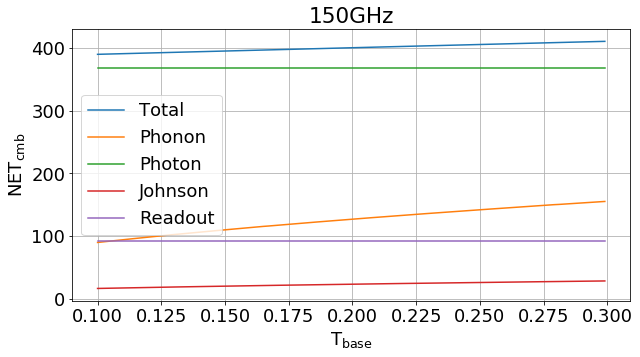

In [157]:
detector, optics = ID.S4_150()
detector, optics = oc.optical_calcs(detector, optics)

tbase_vec = np.arange(0.1,0.3,0.001)  # 0.1 to 0.3K

tot_vec = np.array([])
phonon_vec = np.array([])
johnson_vec = np.array([])
readout_vec = np.array([])
photon_vec = np.array([])
for tbase in tbase_vec:
    # reset the parameters of interest before calling tes_calcs
    detector['T_base'] = tbase
    detector['T_bolo'] = 2*tbase
    detector = tc.tes_calcs(detector)
    tot_vec = np.append(tot_vec,detector['NoiseTotal']['NET_CMB'])
    phonon_vec = np.append(phonon_vec,detector['Phonon']['NET_CMB'])
    johnson_vec = np.append(johnson_vec,detector['Johnson']['NET_CMB'])
    readout_vec = np.append(readout_vec,detector['Readout']['NET_CMB'])
    photon_vec = np.append(photon_vec,detector['Photon']['NET_CMB'])
    
plt.plot(tbase_vec,1e6*tot_vec,label='Total')
plt.plot(tbase_vec,1e6*phonon_vec,label='Phonon')
plt.plot(tbase_vec,1e6*photon_vec,label='Photon')
plt.plot(tbase_vec,1e6*johnson_vec,label='Johnson')
plt.plot(tbase_vec,1e6*readout_vec,label='Readout')
plt.xlabel(r'T$_{\rm base}$')
plt.ylabel(r'NET$_{\rm cmb}$')
plt.title('150GHz')
plt.grid()
plt.legend()
    